In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import cv2
from os import listdir, path, getcwd
import re
from sklearn import preprocessing

cwd = getcwd()

/Users/fineiskid/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# Get greeble filepaths
greeble_imgs = listdir(path.join(cwd, "data"))

# Get sample size, image dimension information
n = len(greeble_imgs)
greeble_0 = cv2.imread(path.join(cwd, 'data', greeble_imgs[0]), cv2.IMREAD_GRAYSCALE)
img_dim = greeble_0.shape
num_pix = greeble_0.ravel().shape[0]

# Initialize greeble image data storage
X = np.zeros([len(greeble_imgs), num_pix])

# Read, reshape, and scale greebles; store each one in a row of X.
for i in range(n):
    X[i,:] = cv2.imread(path.join(cwd, 'data', greeble_imgs[i]), cv2.IMREAD_GRAYSCALE).ravel()/255

# Obtain greeble genders: female == 0, male == 1.
Y = np.array(map(lambda x: int(re.search("^f", x) is None), greeble_imgs))

In [3]:
# Initialize greeble image data storage, obtain SVD.
mean_vec = X.mean(axis = 0)
X_sc = preprocessing.scale(X, with_std = False)
u, s, v = np.linalg.svd(X_sc, full_matrices = False)
Sigma = np.diag(s)
PCs = u.dot(Sigma)

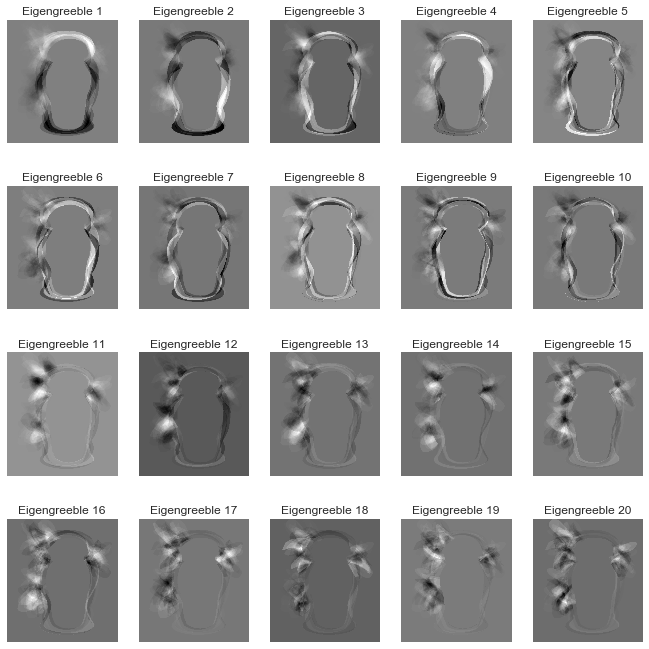

In [18]:
# Plot first 20 EigenGreebles
plt.figure(figsize = [1.8*5, 2.4*4])
plt.subplots_adjust(bottom = 0, left = 0.01, right = 0.99, top = 0.9, hspace = 0.35)
for i in range(20):
    plt.subplot(4, 5, i + 1)
    basis_greeble = np.reshape(v[i,:], img_dim)
    plt.imshow(np.reshape(basis_greeble, img_dim), cmap = plt.cm.gray)
    plt.title("Eigengreeble %d" % (i+1))
    plt.xticks([]); plt.yticks([]) 

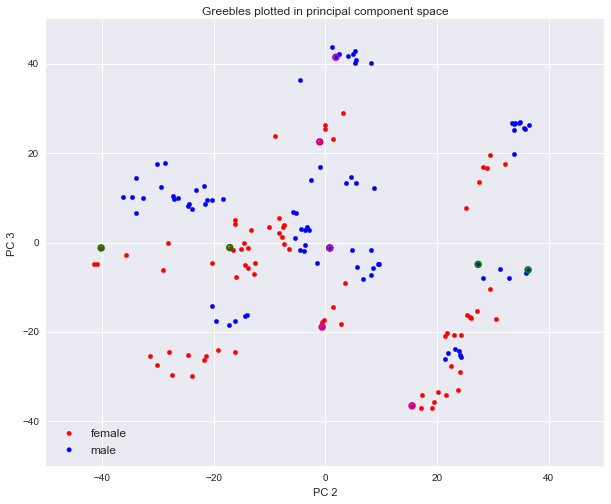

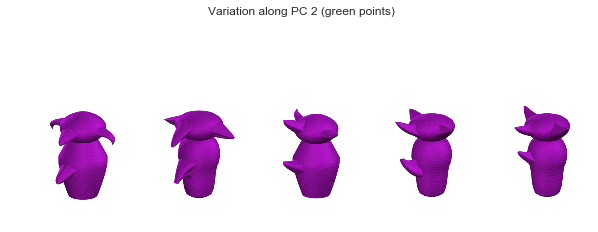

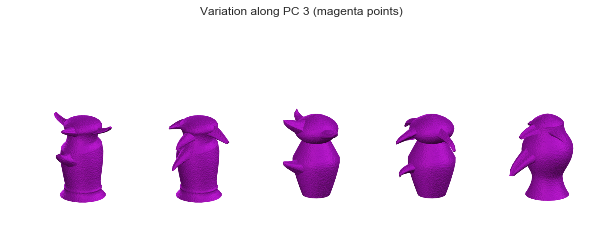

In [200]:
def low_rank_img(img_ind, i, j):
    im = np.zeros(shape = (v.shape[1],))
    for j in range(d):
        im = u[i,j]*s[j]*v[i,:]
    im += mean_vec
    im = im.reshape(img_dim)
    plt.imshow(im*255, cmap = 'gray', interpolation = 'lanczos')
    plt.title("Rank-%d approximation of greeble %d" % (d, i))
    plt.xticks([]); plt.yticks([]) 

def Plot_nearest_to_grid(i, j):
    dat = np.transpose(np.array([PCs[:,i], PCs[:,j]]))
    horiz = np.transpose(np.array([np.linspace(-40, 40, 5), np.zeros([5])])) #(-40, 0), (-20, 0), etc...
    vert = np.transpose(np.array([np.zeros([5]), np.linspace(40, -40, 5)])) #(0, 40), (0, 20), etc...
    horizontal_imgs = []
    vertical_imgs = []
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(1,1,1)
    fem = ax.scatter(PCs[np.where(Y == 0),i], PCs[np.where(Y == 0),j], color = "red")
    male = ax.scatter(PCs[np.where(Y == 1),i], PCs[np.where(Y == 1),j], color = "blue")
    
    ax.set_xlabel("PC %d" % i)
    ax.set_ylabel("PC %d" % j)
    ax.set_title("Greebles plotted in principal component space")
    ax.legend((fem, male),
           ("female", "male"),
           scatterpoints=1,
           loc='lower left',
           fontsize=12)
    
    for i in range(5):
            ptH = horiz[i,:]
            ptV = vert[i,:]
            horiz_greeb_ind = np.argmin([np.linalg.norm(ptH - dat[ii,:]) for ii in range(dat.shape[0])])
            vert_greeb_ind = np.argmin([np.linalg.norm(ptV - dat[ii,:]) for ii in range(dat.shape[0])])
#             ax.scatter(ptH[0], ptH[1], s = 30, facecolors='none', edgecolors='g', linewidths = 2)
#             ax.scatter(ptV[0], ptV[1], s = 30, facecolors='none', edgecolors='g', linewidths = 2)
            ax.scatter(dat[horiz_greeb_ind,0], dat[horiz_greeb_ind,1], s = 30, facecolors = 'none', edgecolors = 'g', linewidths = 2)
            ax.scatter(dat[vert_greeb_ind,0], dat[vert_greeb_ind,1], s = 30, facecolors = 'none', edgecolors = 'm', linewidths = 2)
            horizontal_imgs.append(horiz_greeb_ind); vertical_imgs.append(vert_greeb_ind)
    
    plt.show()
    return(horizontal_imgs, vertical_imgs)


i = 2; j = 3
h, v = Plot_nearest_to_grid(i,j)

fig = plt.figure(figsize = (10,8))
fig.suptitle('Variation along PC %d (green points)'%i)
for i in range(5):
    ax = fig.add_subplot(2,5, i+1)
    img = cv2.imread(path.join(cwd, 'data', greeble_imgs[h[i]]), cv2.IMREAD_COLOR)
    ax.imshow(img)
    ax.axis("off")

fig = plt.figure(figsize = (10,8))
fig.suptitle('Variation along PC %d (magenta points)'%j)
for i in range(5):
    ax = fig.add_subplot(2,5, i+1)
    img = cv2.imread(path.join(cwd, 'data', greeble_imgs[v[i]]), cv2.IMREAD_COLOR)
    ax.imshow(img)
    ax.axis("off")


In [72]:
## Warning: v is *actually* v^T.
u.dot(Sigma).dot(v).shape

(160, 115200)

In [220]:
## NMF!
from sklearn.decomposition import NMF
nmf_model = NMF(n_components=50, init='random', random_state=0)
nmf_model.fit(X) 

NMF(alpha=0.0, beta=1, eta=0.1, init='random', l1_ratio=0.0, max_iter=200,
  n_components=50, nls_max_iter=2000, random_state=0, shuffle=False,
  solver='cd', sparseness=None, tol=0.0001, verbose=0)

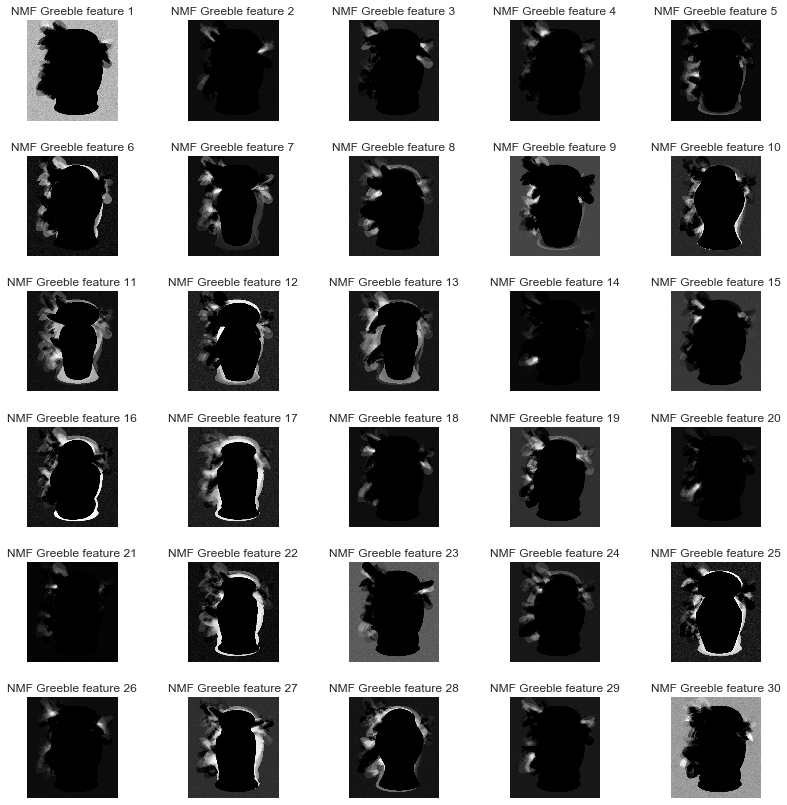

In [221]:
# Plot first 30 NMF bases
plt.figure(figsize = [1.8*6, 2.4*5])
plt.subplots_adjust(bottom = 0, left = 0.05, right = 1.05, top = 0.9, hspace = 0.35)
for i in range(30):
    plt.subplot(6,5, i + 1)
    basis_greeble = np.reshape(nmf_model.components_[i,:], img_dim)
    plt.imshow(np.reshape(basis_greeble, img_dim), cmap = plt.cm.gray)
    plt.title("NMF Greeble feature %d" % (i+1))
    plt.xticks([]); plt.yticks([]) 

In [227]:
# Find each greeble's composition of NMF bases:
X_trans = nmf_model.transform(X) 
X_trans.shape
# 45th greeble's representation via bases:
X_trans[45, :]

array([ 1.65742635,  0.1048836 ,  0.28456011,  0.12440265,  0.0033192 ,
        0.15641665,  0.        ,  0.20494102,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.02639978,  0.518676  ,
        0.        ,  1.19871276,  0.        ,  0.0747972 ,  0.29066973,
        0.09917056,  0.        ,  0.36502876,  0.13427526,  0.00578061,
        0.11016432,  0.        ,  0.        ,  0.        ,  0.19107499,
        0.        ,  0.        ,  0.02805857,  0.28330925,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.45776575,  0.02528398,  0.        ,  0.02000778,
        0.28543026,  0.        ,  0.        ,  0.1623372 ,  0.22595968])

84